In [68]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import scipy.stats as stats

In [40]:
#Signal 
x = np.linspace(0, 1, num=2048)
chirp_signal = np.sin(50 * np.pi * x**2)

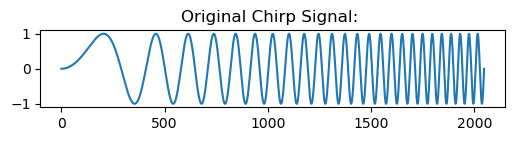

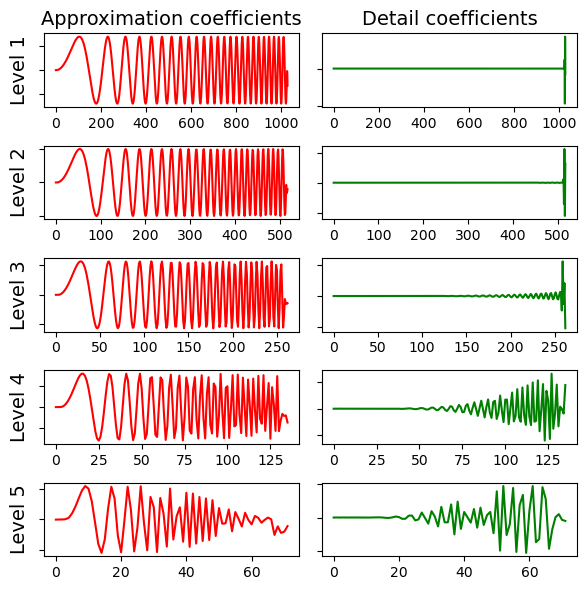

In [41]:
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Chirp Signal: ")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym5'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

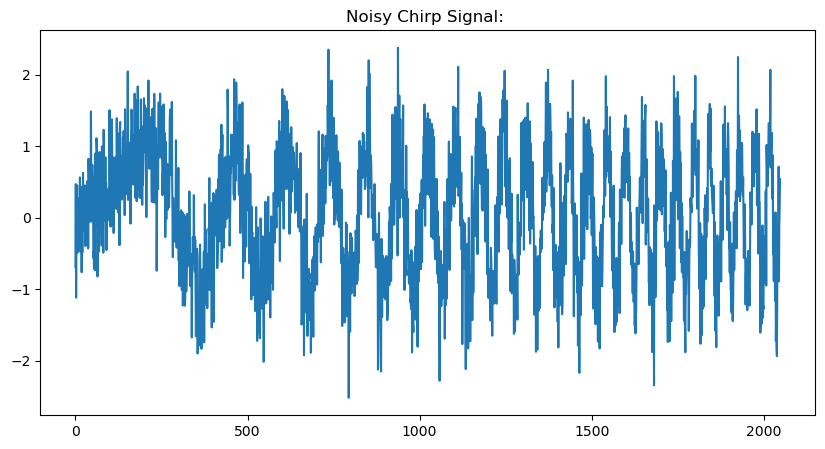

In [176]:
#Let's add noise
data = chirp_signal +  0.5*np.random.randn(len(chirp_signal))
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Noisy Chirp Signal: ")
ax.plot(data)
plt.show()


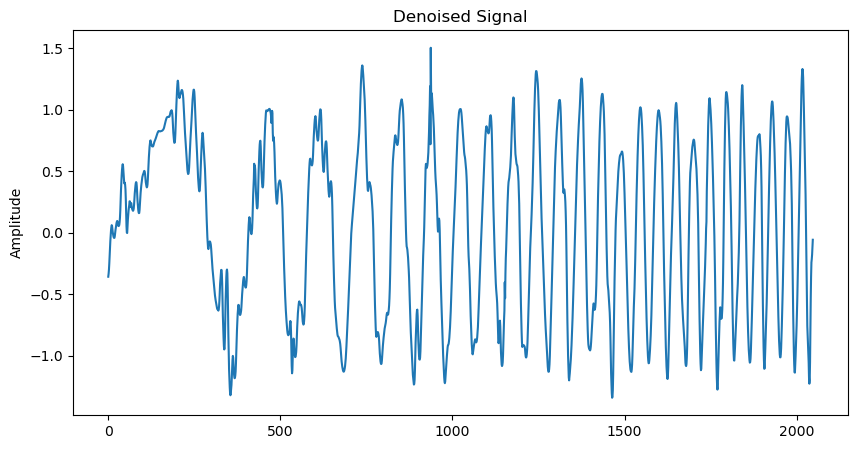

In [201]:
#Now let's denoise the signal
#METHODE BASELINE

waveletname = 'sym5'
coeffs = pywt.wavedec(data, waveletname, level = 3) 


details = coeffs[1:]

new_details = []


for detail in details:
    #Méthode de base : on prend le seuil à 0.9*max (tous ceux en dessous sont tronqués)
    threshold = 0.9*np.max(detail)
    new_detail = pywt.threshold(detail, threshold, mode="soft")
    new_details.append(new_detail)

new_coeffs = [coeffs[0]] + new_details
datarec_baseline = pywt.waverec(new_coeffs, waveletname)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datarec_baseline)
ax.set_title('Denoised Signal')
ax.set_ylabel('Amplitude')
plt.show()

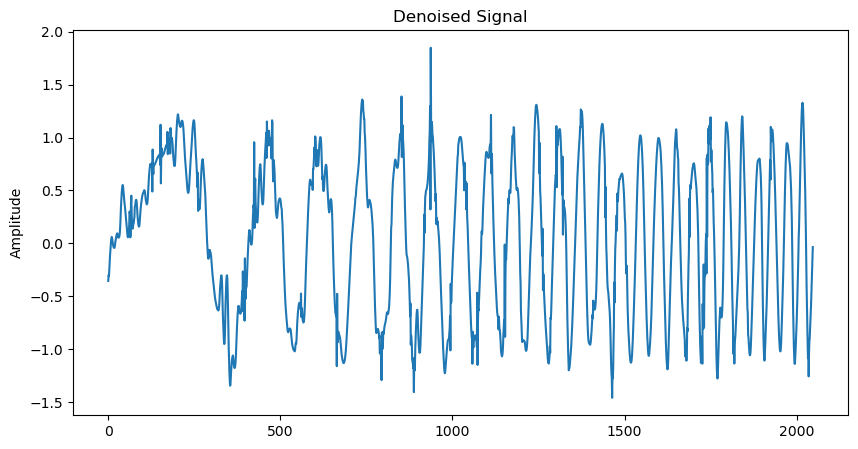

In [209]:
#Now let's denoise the signal
#METHODE DU PAPIER

waveletname = 'sym5'
coeffs = pywt.wavedec(data, waveletname, level = 3) 


details = coeffs[1:]

new_details = []

alpha = 1.5/1000000

for detail in details:
    new_detail = detail.copy()
    s = np.std(detail)
    d = stats.norm.ppf(1 - alpha/2)
    while (np.abs(detail) > s*d).any():
        indices_to_keep = np.argwhere(np.abs(detail) > s*d)
        detail = np.delete(detail, indices_to_keep)
        s = np.std(detail)



        
    threshold = s*d

    new_detail = pywt.threshold(new_detail, threshold, mode="soft")
    new_details.append(new_detail)
    alpha += 1.5/100

new_coeffs = [coeffs[0]] + new_details
datarec_papier = pywt.waverec(new_coeffs, waveletname)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datarec_papier)
ax.set_title('Denoised Signal')
ax.set_ylabel('Amplitude')
plt.show()

In [210]:
print("La RMSE de la méthode du papier est : ")
print(np.sqrt(np.mean(np.square(chirp_signal - datarec_papier))))
print("La RMSE de la la méthode de base est : ")
print(np.sqrt(np.mean(np.square(chirp_signal - datarec_baseline))))

La RMSE de la méthode du papier est : 
0.18453876519449483
La RMSE de la la méthode de base est : 
0.1763265565833378
